# Introduction


We use Ocular Disease Recognition dataset to train a model for Cataract prediction - from eye fundus exam & dyagnosis notes.

In the dataset, annotations were added by trained human readers with quality control management. They classify patient into eight labels including:

* Normal (N);  
* Diabetes (D);  
* Glaucoma (G);  
* Cataract (C);  
* AMD (A);  
* Hypertension (H);  
* Myopia (M);
* Other diseases/abnormalities (O)  

We will select a subset of images for which we can definitely identify if there is a certain pathology (from the associated flag) and which eye is identified with the issue (from the eye diagnosys notes for each eye).

We focus on Cataract.


# Data preparation


## Load packages

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
IMG_SIZE = 224
BATCH_SIZE = 32
NO_EPOCHS = 10
NUM_CLASSES = 2
DATA_FOLDER = "Training Images"
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import cv2 as cv
from random import shuffle 
from IPython.display import SVG
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
%matplotlib inline 


## Load tabelar data (Excel)

In [ ]:
data_df = pd.read_excel(open("data.xlsx", 'rb'), sheet_name='Sheet1')  

In [ ]:
data_df.columns = ["id", 'age', "sex", "left_fundus", "right_fundus", "left_diagnosys", "right_diagnosys", "normal",
                  "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other"]

# Train images

Let's check which images have the `Cataract` flag positive and which images have the eye diagnosys associated clearly stating either `cataract` or `normal`


In [ ]:
print(data_df.loc[(data_df.cataract==1)].shape)
print(data_df.loc[data_df.cataract==0].shape)

(212, 15)
(3288, 15)


In [ ]:
data_df.loc[(data_df.cataract==1)]['left_diagnosys'].value_counts()

left_diagnosys
cataract                                                                   135
normal fundus                                                               24
cataract，lens dust                                                           8
moderate non proliferative retinopathy                                       6
lens dust，cataract                                                           5
mild nonproliferative retinopathy                                            5
lens dust，normal fundus                                                      4
cataract，moderate non proliferative retinopathy                              3
refractive media opacity                                                     3
normal fundus，lens dust                                                      3
severe proliferative diabetic retinopathy                                    2
cataract，mild nonproliferative retinopathy                                   2
drusen，cataract，lens dust            

In [ ]:
data_df.loc[(data_df.cataract==1)]['right_diagnosys'].value_counts()

right_diagnosys
cataract                                                                  127
normal fundus                                                              24
moderate non proliferative retinopathy                                      9
cataract，lens dust                                                          6
drusen                                                                      5
lens dust，cataract                                                          5
mild nonproliferative retinopathy                                           4
refractive media opacity                                                    4
macular epiretinal membrane                                                 3
epiretinal membrane                                                         3
cataract，moderate non proliferative retinopathy                             3
moderate non proliferative retinopathy，cataract                             3
hypertensive retinopathy，cataract               

In [ ]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

In [ ]:
data_df['le_cataract'] = data_df['left_diagnosys'].apply(lambda x: has_cataract_mentioned(x))
data_df['re_cataract'] = data_df['right_diagnosys'].apply(lambda x: has_cataract_mentioned(x))

In [ ]:
cataract_le_list = data_df.loc[(data_df.cataract==1) & (data_df.le_cataract==1)]['left_fundus'].values
cataract_re_list = data_df.loc[(data_df.cataract==1) & (data_df.re_cataract==1)]['right_fundus'].values
print(len(cataract_le_list), len(cataract_re_list))
non_cataract_le_list = data_df.loc[(data_df.cataract==0) & (data_df.left_diagnosys=="normal fundus")]['left_fundus'].sample(150, random_state=314).values
non_cataract_re_list = data_df.loc[(data_df.cataract==0) & (data_df.right_diagnosys=="normal fundus")]['right_fundus'].sample(150, random_state=314).values
print(len(non_cataract_le_list), len(non_cataract_re_list))

159 154
150 150


In [ ]:
cataract_list = np.concatenate((cataract_le_list, cataract_re_list), axis = 0)
non_cataract_list = np.concatenate((non_cataract_le_list, non_cataract_re_list), axis = 0)
print(len(non_cataract_list), len(cataract_list))

300 313


In [ ]:
print(len(os.listdir(DATA_FOLDER)))

7000


In [ ]:
def label_image(label):
    if label == 1:
        return [1,0]
    elif label == 0: 
        return [0,1]

def process_data(data_image_list, DATA_FOLDER, is_cataract):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        label = label_image(is_cataract)
        img = cv.imread(path,cv.IMREAD_COLOR)
        img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

In [ ]:
cat_df = process_data(cataract_list, DATA_FOLDER, 1)

100%|██████████| 313/313 [00:36<00:00,  8.67it/s]


In [ ]:
cat_no_df = process_data(non_cataract_list, DATA_FOLDER, 0)

100%|██████████| 300/300 [00:38<00:00,  7.79it/s]


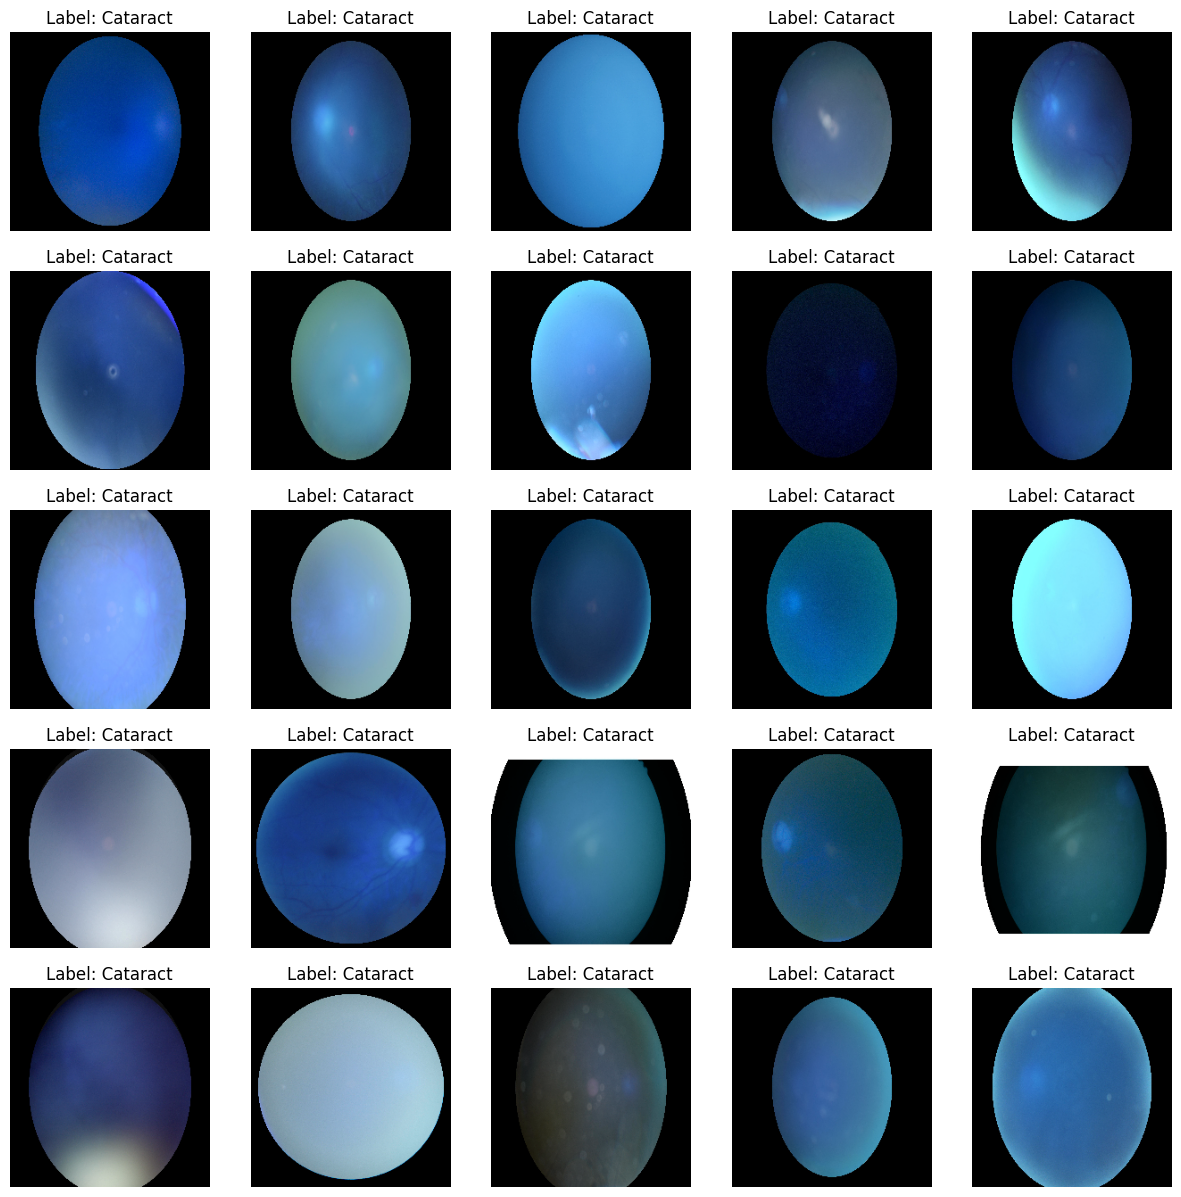

In [ ]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 0: 
            str_label='Cataract'
        elif label == 1: 
            str_label='No Cataract'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(cat_df)

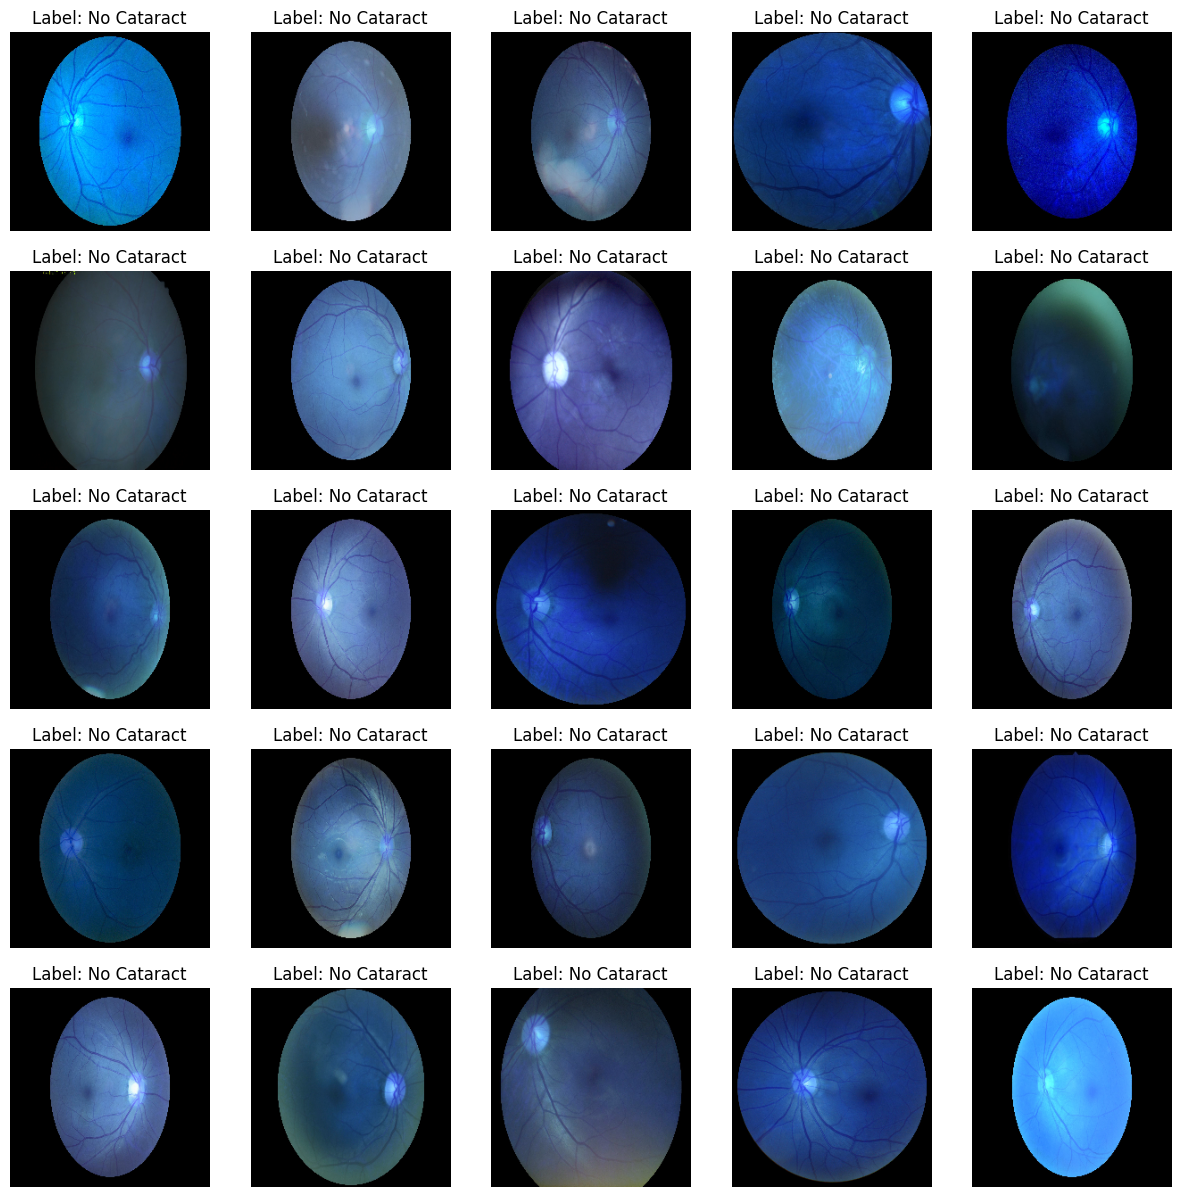

In [ ]:
show_images(cat_no_df)

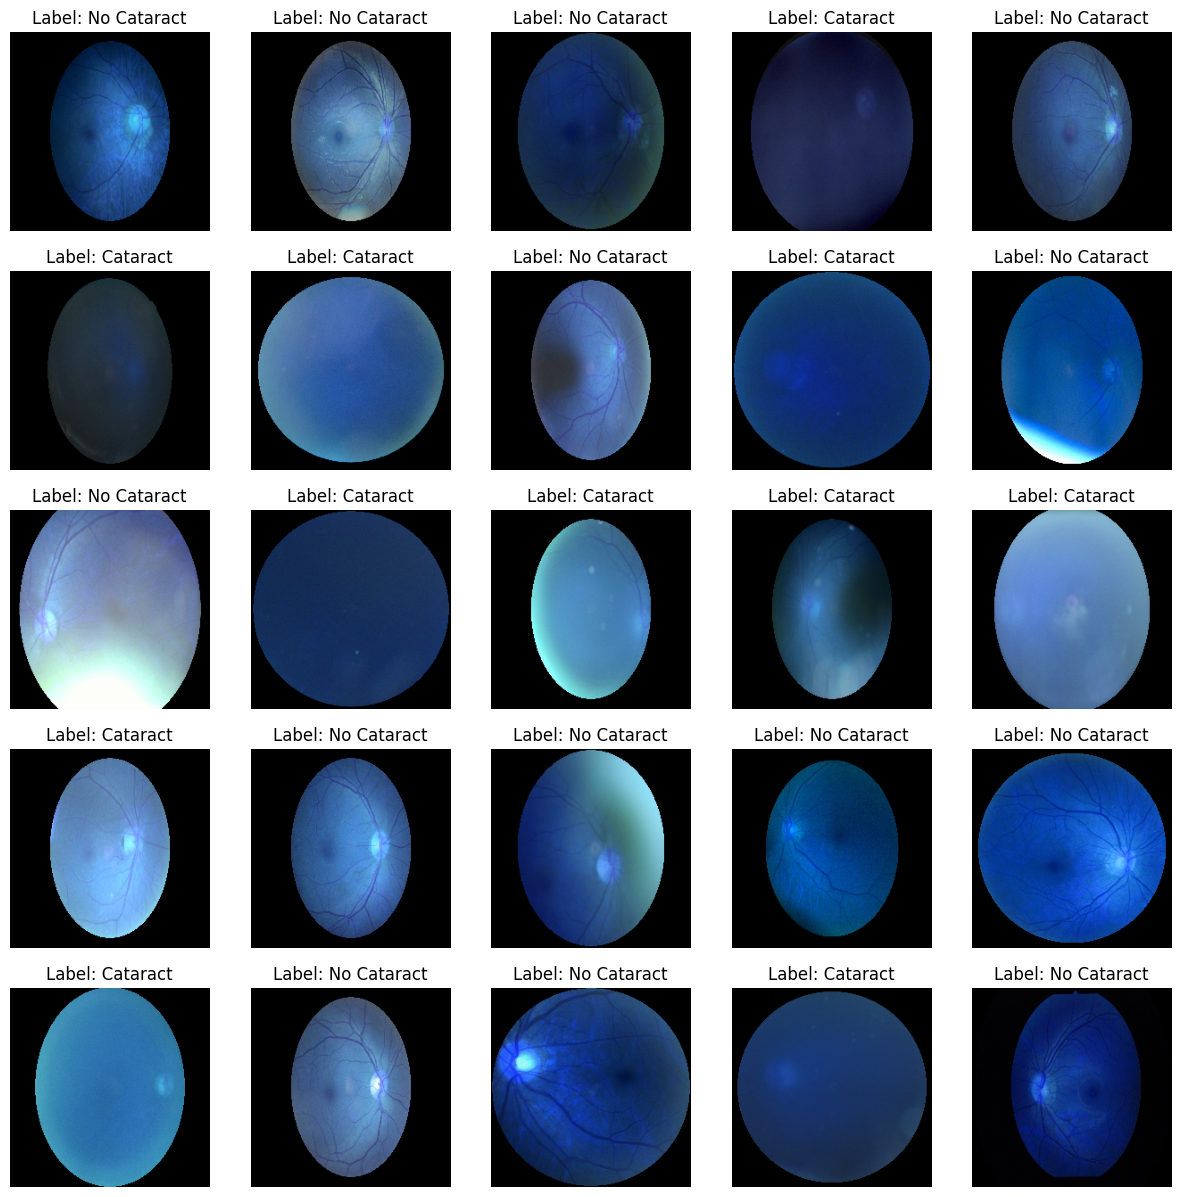

In [ ]:
train = cat_df + cat_no_df
shuffle(train)
show_images(train)

In [ ]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

# Train model

In [ ]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

In [ ]:

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025)
model.compile(optimizer='sgd', loss=loss, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

NameError: name 'plot_model' is not defined

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

## Train model

In [25]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/10
 1/16 ━━━━━━━━━━━━━━━━━━━━ 18:46 75s/step - accuracy: 0.4375 - loss: 5.1423

KeyboardInterrupt: 

## Validation results

In [28]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

NameError: name 'train_model' is not defined

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 2.963881015777588
Validation accuracy: 0.5528455376625061


In [29]:
model_save_path = 'path/to/save/model/cnn_model.h5'  # Specify the desired path
model.save(model_save_path)

In [ ]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [ ]:
target_names = ["Cataract", "Normal"]
print(classification_report(y_true, predicted_classes, target_names=target_names))